In [1]:
%install_ext https://raw.githubusercontent.com/szeitlin/watermark/master/watermark.py

Installed watermark.py. To use it, type:
  %load_ext watermark


In [2]:
%load_ext watermark

In [1]:
import pandas
from dateutil.parser import parse
import pytz

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

%matplotlib inline

In [4]:
%watermark -a "Samantha Zeitlin" -d -u -p python,ipython,pandas,seaborn,pytz,matplotlib

Samantha Zeitlin 
Last updated: 04/28/2015 

python 2.7.9
ipython 3.1.0
pandas 0.16.0
seaborn 0.5.1
pytz 2015.2
matplotlib 1.4.3


In [2]:
font = {'family': 'arial',
        'weight': 'regular',
        'size' : 30}
matplotlib.rc('font', **font)

In [3]:
df = pandas.read_csv("2014_ts.csv",index_col=0, nrows=1000) #just use a subset of the data for testing 

In [4]:
df['parsed']=[parse(x) for x in df['posTime']]
df['zoned'] = [x.astimezone(pytz.timezone('US/Pacific')) for x in df['parsed']]
df.head()

,posTime,Lat,Long,altTime,Altitude,DistanceMeters,weekday,parsed,zoned
0,2014-10-16 07:48:11-07:00,37.3943,-122.0769,2014-10-16 07:48:11-07:00,19.3638,4780.8071,3,2014-10-16 07:48:11-07:00,2014-10-16 07:48:11-07:00
1,2014-10-16 07:48:12-07:00,37.3943,-122.0771,2014-10-16 07:48:12-07:00,19.3638,4791.6362,3,2014-10-16 07:48:12-07:00,2014-10-16 07:48:12-07:00
2,2014-10-16 07:48:17-07:00,37.3944,-122.0774,2014-10-16 07:48:17-07:00,19.8444,4826.5288,3,2014-10-16 07:48:17-07:00,2014-10-16 07:48:17-07:00
3,2014-10-16 07:48:26-07:00,37.3947,-122.0781,2014-10-16 07:48:26-07:00,19.8444,4895.5474,3,2014-10-16 07:48:26-07:00,2014-10-16 07:48:26-07:00
4,2014-10-16 07:48:29-07:00,37.3948,-122.0782,2014-10-16 07:48:29-07:00,19.8444,4916.4795,3,2014-10-16 07:48:29-07:00,2014-10-16 07:48:29-07:00


In [5]:
df = df.sort_index(by='zoned').reset_index()

In [6]:
df['date']=[x.date() for x in df['zoned']]
df.head()

,index,posTime,Lat,Long,altTime,Altitude,DistanceMeters,weekday,parsed,zoned,date
0,974,2014-10-08 16:21:23-07:00,37.3932,-121.9513,2014-10-08 16:21:23-07:00,53.0098,21.4723,2,2014-10-08 16:21:23-07:00,2014-10-08 16:21:23-07:00,2014-10-08
1,975,2014-10-08 16:21:24-07:00,37.3932,-121.9512,2014-10-08 16:21:24-07:00,53.0098,27.8743,2,2014-10-08 16:21:24-07:00,2014-10-08 16:21:24-07:00,2014-10-08
2,976,2014-10-08 16:21:34-07:00,37.3935,-121.9506,2014-10-08 16:21:34-07:00,53.0098,93.1674,2,2014-10-08 16:21:34-07:00,2014-10-08 16:21:34-07:00,2014-10-08
3,977,2014-10-08 16:21:38-07:00,37.3936,-121.9504,2014-10-08 16:21:38-07:00,52.0486,114.1827,2,2014-10-08 16:21:38-07:00,2014-10-08 16:21:38-07:00,2014-10-08
4,978,2014-10-08 16:21:42-07:00,37.3937,-121.9503,2014-10-08 16:21:42-07:00,53.4905,130.7530,2,2014-10-08 16:21:42-07:00,2014-10-08 16:21:42-07:00,2014-10-08


In [7]:
df.shape

(1000, 11)

In [8]:
df['date'].value_counts()

2014-10-16    490
2014-10-21    406
2014-10-20     78
2014-10-08     26
dtype: int64

In [9]:
#for row in df, while date.next == date.previous, append to list
#otherwise, stop and create new list 

def split_alts_by_date(df, datecolname):
    """ Create lists of altitudes from points visited on the same day (dates will be the same, times will vary).
    
    Note: assumes the df is sorted, with index reset, such that index follows the right order for sequential date values.
    
    sorted df (dataframe), datecolname (str) -> generator of lists of altitudes in meters
    
    """
    alt_list = []
    
    temp_date = df[datecolname][0].date()
    for item in df.index.values:  
        if df[datecolname][item].date() == temp_date:
            alt_list.append((df['DistanceMeters'][item], df['Altitude'][item]))
        
        else:
            temp_date = df[datecolname][item].date()
            yield alt_list


In [10]:
def collapse_to_unique_points(alt_list):
    """ Remove adjacent duplicates. 

    :param alt_list: list of tuples
    :return: points: shorter list of tuples
    """
    points = []
    print len(alt_list)
    for item in alt_list:
        if len(points)==0 or item != points[-1]:  #compare to element most recently appended to points
            points.append(item)
    print len(points)
    return points

In [28]:
def plot_maker():
    """
    Helper function to set up a new plot with the formatting I want. 
    
    :param dist_df: dataframe with distance and altitude columns
    :return: a plot 
    
    """
    dist_df = df_maker(df, 'zoned')
    
    while dist_df:
        try:
            plot_frame = next(dist_df)
            fig= plt.figure(figsize=(8,4),dpi=250)
            ax = fig.add_subplot(111)
            ax.plot(plot_frame['distance'],plot_frame['altitude'])
            ax.set_ylabel('Altitude(meters)', fontsize=20)
            ax.set_xlabel('Distance(meters)', fontsize=20)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
        except StopIteration:
            break 

In [29]:
def df_maker(df, datecolname):
    """
    Run this to get plots of altitudes by date (supposedly.)
    """
    alt_list = split_alts_by_date(df, 'zoned')
    
    while alt_list:
        try:
            points = next(alt_list)
            dist_df = pandas.DataFrame(points, columns=['distance','altitude'])
            print dist_df.count()
            yield dist_df
            
        except StopIteration:
            break
    

distance    26
altitude    26
dtype: int64
distance    515
altitude    515
dtype: int64
distance    592
altitude    592
dtype: int64


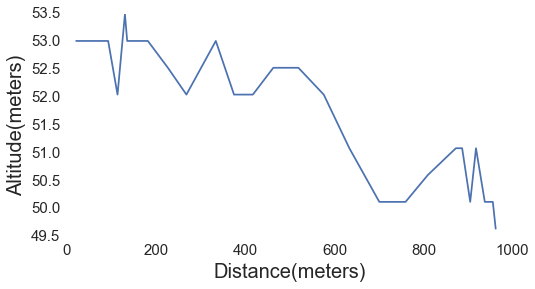

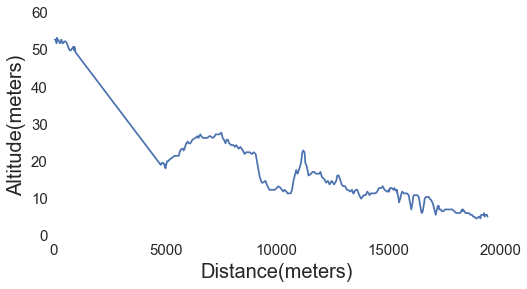

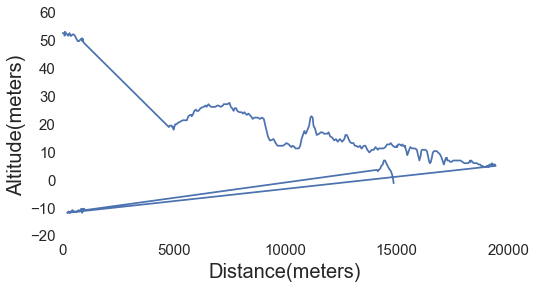

In [30]:
table = plot_maker()

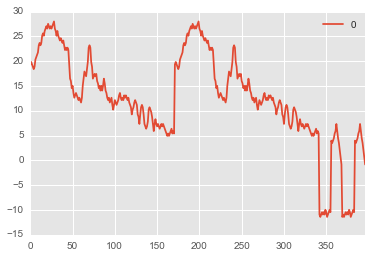

In [47]:
points2 = pandas.Series(points2)
points2 = pandas.DataFrame(points2)
points2.plot()

In [48]:
alts3 = next(altitude)
points3 = collapse_to_unique_points(alts3)

972
698


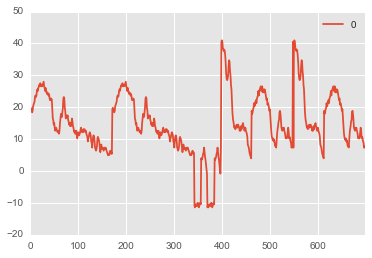

In [49]:
points3 = pandas.Series(points3)
points3 = pandas.DataFrame(points3)
points3.plot()
#plt.ylabel('measured altitude(meters)')
#plt.xlabel('indexed measurement')

In [9]:
#for row in df, while date.next == date.previous, append to list
#otherwise, stop and create new list 

def split_locs_by_date(df, datecolname):
    """ Create lists of lat and long from points visited on the same day (dates will be the same, times will vary).
    
    Note: assumes the df is sorted, with index reset, such that index follows the right order for sequential date values.
    
    sorted df (dataframe), datecolname (str) -> generator of lists of lat/long tuples
    
    """
    loc_list = []
    
    temp_date = df[datecolname][0].date()
    for item in df.index.values:  
        if df[datecolname][item].date() == temp_date:
            loc_list.append((df['Lat'][item],df['Long'][item]))
        
        else:
            temp_date = df[datecolname][item].date()
            yield loc_list
    

In [10]:
#test split_by_date
loc_1 = split_locs_by_date(df, 'zoned')

In [11]:
points = next(loc_1)

In [12]:
print points, len(path)

[(37.394300000000001, -122.07689999999999), (37.394300000000001, -122.0771), (37.394399999999997, -122.0774), (37.3947, -122.07810000000001), (37.394799999999996, -122.0782), (37.395000000000003, -122.0782), (37.395299999999999, -122.0779), (37.395299999999999, -122.0779), (37.395400000000002, -122.07769999999999), (37.395400000000002, -122.0776), (37.395099999999999, -122.07700000000001), (37.3949, -122.07640000000001), (37.3947, -122.0758), (37.394199999999998, -122.0746), (37.393799999999999, -122.0736), (37.3934, -122.0727), (37.393000000000001, -122.07170000000001), (37.392800000000001, -122.0711), (37.392400000000002, -122.0702), (37.392099999999999, -122.0697), (37.392099999999999, -122.06959999999999), (37.3919, -122.06910000000001), (37.391599999999997, -122.0684), (37.391399999999997, -122.0677), (37.391199999999998, -122.0673), (37.390900000000002, -122.0665), (37.390500000000003, -122.0656), (37.390000000000001, -122.0643), (37.389600000000002, -122.06319999999999), (37.389

NameError: name 'path' is not defined

In [97]:
locations = [(row[1],row[2]) for row in df[['Lat','Long']].itertuples()]
print('\n'.join(str(x) for x in [locations[0],locations[1]]))

(37.394300000000001, -122.07689999999999)
(37.394300000000001, -122.0771)


In [ ]:
#want to extract lat and long from df based on date and feed it in as a path 


In [141]:
#get elevations back and plot them
elevations = [5.627086639404297, 5.839840412139893, 5.483985424041748, 5.309235572814941, 5.852761745452881, 5.960859775543213, 5.806560516357422, 6.369852542877197, 6.051360130310059, 7.211959362030029, 7.365567207336426, 8.226292610168457, 6.00233268737793, 5.292089939117432, 5.007282257080078, 5.485466957092285, 6.159402370452881, 6.032011985778809, 5.825675964355469, 6.803745269775391, 6.615157127380371, 7.041442394256592, 7.26495885848999, 8.15757942199707, 8.358736991882324, 8.171339988708496, 9.118271827697754, 9.259295463562012, 9.994961738586426, 9.843290328979492, 10.59953498840332, 11.63686466217041, 12.35517120361328, 12.22323799133301, 13.69894313812256, 15.62654495239258, 15.67187404632568, 17.01805877685547, 17.14420890808105, 17.4635181427002, 19.87927436828613, 19.89750289916992, 21.23011016845703, 21.92111968994141, 22.83876800537109, 24.1338062286377, 24.60493278503418, 23.86082649230957, 22.81315612792969, 23.10221862792969, 22.74290657043457, 22.27962875366211, 22.03162384033203, 22.9021110534668, 24.29611206054688, 25.30944633483887, 27.05757331848145, 27.76638793945312, 28.46392059326172, 28.62152481079102, 28.50705528259277, 28.08891868591309]
elevated = pandas.Series(elevations)

In [142]:
df = pandas.DataFrame(elevated)

(array([  5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 6 Text yticklabel objects>)

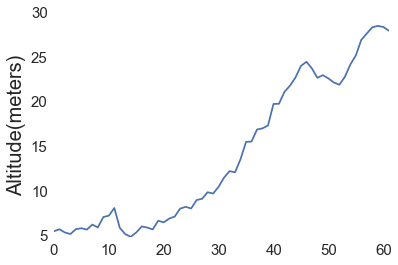

In [143]:
ax = df.plot(legend=False)
ax.set_ylabel('Altitude(meters)', fontsize=20)
#ax.set_xlabel('Distance(meters)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [45]:
#would be nicer to be able to plot this over time, but it's pretty consistent with what cycleroute.org gave 
#for comparison, the Eiffel Tower is 300 m tall, potrero hill is 46 m (150 ft) 

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 7 Text yticklabel objects>)

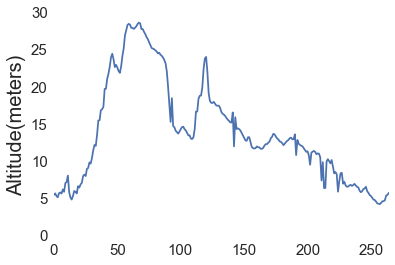

In [145]:
ele2=[28.08170700073242, 27.94421195983887, 28.10497665405273, 28.29936790466309, 28.60774993896484, 28.78005599975586, 28.68700981140137, 27.90944862365723, 27.9266529083252, 27.56032943725586, 27.25487327575684, 26.85952186584473, 26.57603645324707, 26.19034576416016, 25.80401992797852, 25.38783836364746, 25.28845405578613, 25.21034812927246, 25.05902290344238, 24.9037971496582, 24.64801788330078, 24.74091339111328, 24.47681427001953, 24.3245792388916, 24.09706497192383, 23.77349853515625, 23.33495712280273, 22.24639320373535, 20.17004013061523, 17.80467796325684, 15.44187259674072, 18.63554382324219, 14.88895511627197, 14.71258354187012, 14.255690574646, 14.07004642486572, 13.86791133880615, 14.14136981964111, 14.47133445739746, 14.74272537231445, 14.80256366729736, 14.471116065979, 14.29596710205078, 13.9620246887207, 13.62836933135986, 13.63751220703125, 13.20072841644287, 13.14438915252686, 13.37343120574951, 14.48258495330811, 16.82987403869629]
ele3 = [16.82987403869629, 18.55566215515137, 18.9598217010498, 18.98641395568848, 20.05703163146973, 22.54707145690918, 23.96240615844727, 24.18024826049805, 22.18376541137695, 19.31110954284668, 18.25616645812988, 18.00452613830566, 17.99230194091797, 18.13630104064941, 17.88492774963379, 17.65925025939941, 17.61457443237305, 17.62855529785156, 17.34478187561035, 16.78891754150391, 16.53693008422852, 16.42161750793457, 16.24383735656738, 15.98143482208252, 15.75777912139893, 15.58979320526123, 15.38829040527344, 15.36117839813232, 16.71587944030762, 12.15573024749756, 16.07232475280762, 14.4774341583252, 14.5739221572876, 14.4799861907959, 14.29948711395264, 13.97274303436279, 13.66981029510498, 13.30011081695557, 12.95280170440674, 12.90287780761719, 13.3678674697876, 13.39457511901855, 12.74958896636963, 12.07607173919678, 11.92678165435791, 11.8585958480835, 11.92796802520752, 12.14534378051758, 12.03651905059814, 12.01804065704346, 11.82767868041992]
ele4 = [11.82767868041992, 11.94652843475342, 12.25741386413574, 12.45300960540771, 12.45341777801514, 12.64653396606445, 12.80097961425781, 13.24417018890381, 13.4389123916626, 13.84096145629883, 13.76000690460205, 13.46513843536377, 13.22171974182129, 13.07826995849609, 12.82023811340332, 12.76106834411621, 12.58297634124756, 12.3135404586792, 12.5082483291626, 12.743408203125, 12.90487384796143, 13.03140258789062, 13.25526332855225, 13.33150386810303, 13.09617805480957, 13.12234783172607, 13.78225612640381, 10.97945404052734, 13.01733207702637, 12.50856494903564, 12.35006523132324, 12.23793315887451, 12.16549205780029, 11.90487670898438, 11.64395332336426, 11.41952133178711, 11.49758338928223, 10.92479801177979, 9.680747985839844, 11.29688930511475, 11.45321941375732, 11.54148101806641, 11.41617202758789, 11.09461402893066, 11.21470832824707, 11.17489814758301, 10.67293453216553, 7.572116851806641, 10.03211307525635, 6.551140785217285]
ele5 = [6.551140785217285, 10.12997722625732, 10.43397235870361, 10.1801233291626, 9.874947547912598, 10.31869888305664, 9.441795349121094, 8.52158260345459, 8.707115173339844, 8.393967628479004, 6.061867713928223, 7.457648277282715, 8.530965805053711, 8.602157592773438, 7.129727363586426, 7.390824794769287, 6.904690742492676, 6.727382183074951, 6.753885269165039, 6.907939434051514, 6.977006912231445, 6.847075462341309, 6.943768501281738, 7.119138717651367, 6.895820140838623, 6.720235347747803, 6.63393497467041, 6.207952976226807, 5.994878768920898, 6.120191097259521, 6.417147636413574, 6.495415687561035, 6.727447986602783, 6.126497745513916, 5.909664630889893, 5.610713958740234, 5.480751514434814, 5.238534450531006, 4.99930477142334, 4.938337802886963, 4.731930732727051, 4.483243942260742, 4.447968006134033, 4.390510559082031, 4.561434745788574, 4.775047302246094, 4.779616355895996, 4.930953502655029, 5.549715042114258, 5.633944034576416, 5.893264770507812]
ele2series = pandas.Series(elevations + ele2 + ele3+ ele4 + ele5)
df2 = pandas.DataFrame(ele2series)
ax = df2.plot(legend=False) 
ax.set_ylabel('Altitude(meters)', fontsize=20)
#ax.set_xlabel('Distance(meters)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)